In [1]:
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
# sklearn Preprocessing
from sklearn.model_selection import train_test_split
#Keras
import keras
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
import split_folders
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio('./img_data/', output="./data", seed=1337, ratio=(.8, .2)) # default values

Copying files: 1000 files [00:10, 100.00 files/s]


In [6]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255, so aftre this step all our pixel values are in range (0,1)
        shear_range=0.2, #to apply some random tranfromations
        zoom_range=0.2, #to apply zoom
        horizontal_flip=True) # image will be flipper horiz
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
training_set = train_datagen.flow_from_directory(
        './data/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)
test_set = test_datagen.flow_from_directory(
        './data/val',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False )

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [8]:
model = Sequential()
input_shape=(64, 64, 3)#1st hidden layer
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#2nd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#Flatten
model.add(Flatten())
model.add(Dropout(rate=0.5))#Add fully connected layer.
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))#Output layer
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 31, 32)        896       
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)         

In [9]:
epochs = 200
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, 
          momentum=momentum, 
          decay=decay_rate, 
          nesterov=False)

model.compile(optimizer="sgd", 
              loss="categorical_crossentropy", 
              metrics=['accuracy'])

In [11]:
history = model.fit_generator(
        training_set,
        steps_per_epoch=100,
        epochs=50,
        validation_data=test_set,
        validation_steps=200)

#Model Evaluation
results=model.evaluate_generator(generator=test_set, steps=50)
print('test loss, test acc:', results)


Epoch 1/50
100/100 [==============================] - 99s 993ms/step - loss: 2.3075 - accuracy: 0.0794 - val_loss: 2.2771 - val_accuracy: 0.1337
Epoch 2/50
100/100 [==============================] - 102s 1s/step - loss: 2.3018 - accuracy: 0.1047 - val_loss: 2.3017 - val_accuracy: 0.1701
Epoch 3/50
100/100 [==============================] - 97s 968ms/step - loss: 2.2953 - accuracy: 0.1194 - val_loss: 2.2134 - val_accuracy: 0.1561
Epoch 4/50
100/100 [==============================] - 91s 914ms/step - loss: 2.2871 - accuracy: 0.1316 - val_loss: 2.2963 - val_accuracy: 0.1436
Epoch 5/50
100/100 [==============================] - 95s 951ms/step - loss: 2.2766 - accuracy: 0.1341 - val_loss: 2.3966 - val_accuracy: 0.1840
Epoch 6/50
100/100 [==============================] - 92s 924ms/step - loss: 2.2623 - accuracy: 0.1494 - val_loss: 2.2952 - val_accuracy: 0.1841
Epoch 7/50
100/100 [==============================] - 98s 981ms/step - loss: 2.2445 - accuracy: 0.1641 - val_loss: 2.0087 - val_accu

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


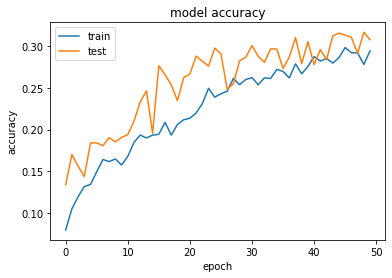

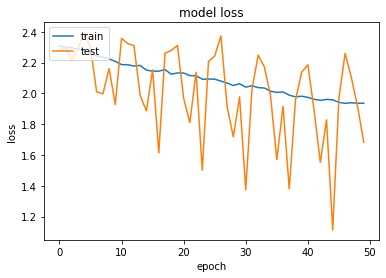

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_loss')
plt.show()

In [14]:
test_set.reset()
pred = model.predict_generator(test_set, steps=50, verbose=1)

50/50 [==============================] - 15s 300ms/step


In [15]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

In [18]:
print(len(filenames), len(predictions))


200 200


In [22]:
dict_ = {"Filename":filenames,
        "Predictions":predictions}
prepared_dict = {i: x for i, x in enumerate(dict_.items())}
results=pd.DataFrame.from_dict(prepared_dict, 
                      orient='index',
                      columns=['Filename', 'Prediction'])
results.to_csv("prediction_results.csv",index=False)

In [23]:
from keras.models import load_model
model.save('CCN_genre_clf_1.sav')
print('model saved')

model saved


In [24]:
epochs = 200
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, 
          momentum=momentum, 
          decay=decay_rate, 
          nesterov=False)

model.compile(optimizer="sgd", 
              loss="categorical_crossentropy", 
              metrics=['accuracy'])


history = model.fit_generator(
        training_set,
        steps_per_epoch=100,
        epochs=150,
        validation_data=test_set,
        validation_steps=200)

#Model Evaluation
results=model.evaluate_generator(generator=test_set, steps=50)
print('test loss, test acc:', results)


/step - loss: 1.8858 - accuracy: 0.3078 - val_loss: 1.7153 - val_accuracy: 0.3132
Epoch 16/150
100/100 [==============================] - 99s 995ms/step - loss: 1.8870 - accuracy: 0.3066 - val_loss: 1.9006 - val_accuracy: 0.3224
Epoch 17/150
100/100 [==============================] - 95s 949ms/step - loss: 1.8837 - accuracy: 0.3200 - val_loss: 1.1743 - val_accuracy: 0.3205
Epoch 18/150
100/100 [==============================] - 92s 922ms/step - loss: 1.8737 - accuracy: 0.3122 - val_loss: 2.0071 - val_accuracy: 0.3131
Epoch 19/150
100/100 [==============================] - 102s 1s/step - loss: 1.8800 - accuracy: 0.3081 - val_loss: 2.1825 - val_accuracy: 0.3209
Epoch 20/150
100/100 [==============================] - 115s 1s/step - loss: 1.8721 - accuracy: 0.3106 - val_loss: 2.2608 - val_accuracy: 0.3326
Epoch 21/150
100/100 [==============================] - 97s 974ms/step - loss: 1.8754 - accuracy: 0.3091 - val_loss: 1.7464 - val_accuracy: 0.3170
Epoch 22/150
100/100 [==================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


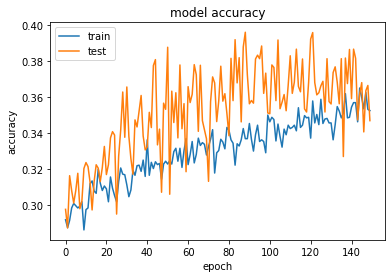

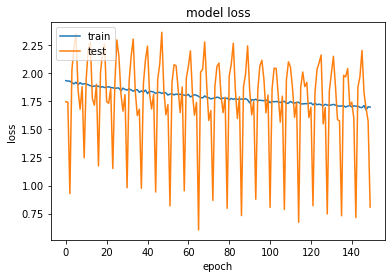

In [25]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_accuracy_1')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_loss_1')
plt.show()

In [27]:
test_set.reset()
pred = model.predict_generator(test_set, steps=150, verbose=1)

150/150 [==============================] - 47s 315ms/step


In [28]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

In [30]:
print(len(filenames), len(predictions))

200 200


In [31]:
dict_ = {"Filename":filenames,
        "Predictions":predictions}
prepared_dict = {i: x for i, x in enumerate(dict_.items())}
results=pd.DataFrame.from_dict(prepared_dict, 
                      orient='index',
                      columns=['Filename', 'Prediction'])
results.to_csv("prediction_results_2.csv",index=False)

In [32]:
from keras.models import load_model
model.save('CCN_genre_clf_2.sav')
print('model saved')

model saved
